# Previsão de Posse de Computador Residencial: Uma Análise Usando o Dataset da PNS 2019

In [1]:
!pip install keras
!pip install minisom

In [3]:
pip install pandas seaborn numpy matplotlib imbalanced-learn scikit-learn scipy tensorflow minisom

Note: you may need to restart the kernel to use updated packages.


In [24]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from minisom import MiniSom
import os
import subprocess


2025-03-19 18:19:16.428625: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-19 18:19:16.485301: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-19 18:19:16.536226: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742419156.588477   23091 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742419156.603231   23091 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-19 18:19:16.717267: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## Importação dos dados

In [8]:
# Baixando a base de dados
url = "https://www.pns.icict.fiocruz.br/wp-content/uploads/2023/11/pns2019.zip"
zip_filename = "pns2019.zip"

subprocess.run(["wget", "-c", url, "-O", zip_filename])

# Extrair diretamente no diretório atual (sem subpasta)
subprocess.run(["unzip", "-q", "-j", zip_filename])

os.remove(zip_filename)


--2025-03-19 18:20:23--  https://www.pns.icict.fiocruz.br/wp-content/uploads/2023/11/pns2019.zip
Resolvendo www.pns.icict.fiocruz.br (www.pns.icict.fiocruz.br)... 157.86.16.30
Conectando-se a www.pns.icict.fiocruz.br (www.pns.icict.fiocruz.br)|157.86.16.30|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 200 OK
Tamanho: 49294350 (47M) [application/zip]
Salvando em: “pns2019.zip”

     0K .......... .......... .......... .......... ..........  0% 1,67M 28s
    50K .......... .......... .......... .......... ..........  0% 1,72M 28s
   100K .......... .......... .......... .......... ..........  0% 10,4M 20s
   150K .......... .......... .......... .......... ..........  0% 1,66M 22s
   200K .......... .......... .......... .......... ..........  0% 7,89M 19s
   250K .......... .......... .......... .......... ..........  0% 2,22M 19s
   300K .......... .......... .......... .......... ..........  0%  857K 24s
   350K .......... .......... .......... .......... ..

In [9]:
data = pd.read_csv('pns2019.csv',nrows=100000)

# Análise da base

## Dicionário de Dados

### Questionário sobre Condições de Moradia

#### A001 (A1): Tipo do Domicílio  
- **Valores possíveis:**
  - 1: Casa
  - 2: Apartamento
  - 3: Habitação em casa de cômodos, cortiço ou cabeça de porco
  - 9: Ignorado
  - N/A: Não aplicável

#### A002010 (A2a): Material Predominante nas Paredes Externas  
- **Valores possíveis:**
  - 1: Alvenaria com revestimento
  - 2: Alvenaria sem revestimento
  - 3: Taipa sem revestimento
  - 4: Madeira apropriada
  - 5: Madeira aproveitada
  - 6: Outro material
  - 9: Ignorado
  - N/A: Não aplicável

#### A003010 (A3a): Material Predominante na Cobertura  
- **Valores possíveis:**
  - 1: Telha sem laje
  - 2: Telha com laje
  - 3: Somente laje
  - 4: Madeira apropriada
  - 5: Zinco, alumínio ou chapa metálica
  - 6: Outro material
  - 9: Ignorado
  - N/A: Não aplicável

#### A004010 (A4a): Material Predominante no Piso  
- **Valores possíveis:**
  - 1: Cerâmica, lajota ou pedra
  - 2: Madeira apropriada
  - 3: Cimento
  - 4: Terra
  - 5: Outro material
  - 9: Ignorado
  - N/A: Não aplicável

#### A01001 (A10a): Quantidade de Cômodos no Domicílio  
- **Valores possíveis:**
  - 01 a 30: Quantidade de cômodos
  - 99: Ignorado
  - N/A: Não aplicável

#### A011: Quantidade de Dormitórios  
- **Valores possíveis:**
  - 01 a 15: Quantidade de dormitórios
  - 99: Ignorado
  - N/A: Não aplicável

#### A005010 (A5a): Principal Forma de Abastecimento de Água  
- **Valores possíveis:**
  - 1: Rede geral
  - 2: Poço profundo
  - 3: Poço raso
  - 4: Fonte ou nascente
  - 5: Água da chuva
  - 6: Outra
  - 9: Ignorado
  - N/A: Não aplicável

#### A005012 (A5b): Está Ligado à Rede Geral de Água?  
- **Valores possíveis:**
  - 1: Sim
  - 2: Não
  - 9: Ignorado
  - N/A: Não aplicável

#### A00601 (A6a): Água Canalizada  
- **Valores possíveis:**
  - 1: Canalizada em cômodo
  - 2: Canalizada no terreno
  - 3: Não canalizada
  - 9: Ignorado
  - N/A: Não aplicável

#### A009010 (A9a): Água para Beber  
- **Valores possíveis:**
  - 1: Filtrada
  - 2: Fervida
  - 3: Tratada com cloro
  - 4: Outra forma
  - 5: Mineral industrializada
  - 6: Sem tratamento
  - 9: Ignorado
  - N/A: Não aplicável

#### A01401 (A14a): Quantidade de Banheiros Exclusivos  
- **Valores possíveis:**
  - 01 a 15: Quantidade de banheiros
  - 0: Nenhum
  - 99: Ignorado
  - N/A: Não aplicável

#### A01402 (A14b): Quantidade de Banheiros de Uso Comum  
- **Valores possíveis:**
  - 01 a 15: Quantidade de banheiros
  - 00: Nenhum
  - 99: Ignorado
  - N/A: Não aplicável

#### A01403 (A14c): Uso de Sanitário ou Buraco para Dejeções  
- **Valores possíveis:**
  - 1: Sim
  - 2: Não
  - 9: Ignorado
  - N/A: Não aplicável

#### A01501 (A15a): Destino do Esgoto  
- **Valores possíveis:**
  - 1: Rede geral
  - 2: Fossa séptica ligada
  - 3: Fossa não ligada
  - 4: Fossa rudimentar
  - 5: Vala
  - 6: Rio ou lago
  - 7: Outra
  - 9: Ignorado
  - N/A: Não aplicável

#### A016010 (A16a): Destino do Lixo  
- **Valores possíveis:**
  - 1: Coletado por serviço
  - 2: Coletado em caçamba
  - 3: Queimado
  - 4: Enterrado
  - 5: Jogado em terreno baldio
  - 6: Outro
  - 9: Ignorado
  - N/A: Não aplicável

#### A018011 (A18a): Existe Televisão em Cores?  
- **Valores possíveis:**
  - 1: Sim
  - 2: Não
  - 9: Ignorado
  - N/A: Não aplicável

#### A018012 (A18a): Quantidade de Televisões em Cores  
- **Valores possíveis:**
  - 01 a 98: Quantidade
  - 99: Ignorado
  - N/A: Não aplicável

#### A018013 (A18a): Existe Geladeira?  
- **Valores possíveis:**
  - 1: Sim
  - 2: Não
  - 9: Ignorado
  - N/A: Não aplicável

#### A018014 (A18a): Quantidade de Geladeiras  
- **Valores possíveis:**
  - 01 a 98: Quantidade
  - 99: Ignorado
  - N/A: Não aplicável

#### A018015 (A18a): Existe Máquina de Lavar Roupa?  
- **Valores possíveis:**
  - 1: Sim
  - 2: Não
  - 9: Ignorado
  - N/A: Não aplicável

#### A018016 (A18a): Quantidade de Máquinas de Lavar Roupa  
- **Valores possíveis:**
  - 01 a 98: Quantidade
  - 99: Ignorado
  - N/A: Não aplicável

#### A018017 (A18a): Existe Telefone Fixo?  
- **Valores possíveis:**
  - 1: Sim
  - 2: Não
  - 9: Ignorado
  - N/A: Não aplicável

#### A018018 (A18a): Quantidade de Telefones Fixos  
- **Valores possíveis:**
  - 01 a 98: Quantidade
  - 99: Ignorado
  - N/A: Não aplicável

#### A018019 (A18a): Existe Telefone Celular?  
- **Valores possíveis:**
  - 1: Sim
  - 2: Não
  - 9: Ignorado
  - N/A: Não aplicável

#### A018020 (A18a): Quantidade de Celulares  
- **Valores possíveis:**
  - 01 a 98: Quantidade
  - 99: Ignorado
  - N/A: Não aplicável

#### A018021 (A18a): Existe Forno Micro-ondas?  
- **Valores possíveis:**
  - 1: Sim
  - 2: Não
  - 9: Ignorado
  - N/A: Não aplicável

#### A018022 (A18a): Quantidade de Fornos Micro-ondas  
- **Valores possíveis:**
  - 01 a 98: Quantidade
  - 99: Ignorado
  - N/A: Não aplicável

#### A018023 (A18a): Existe Computador?  
- **Valores possíveis:**
  - 1: Sim
  - 2: Não
  - 9: Ignorado
  - N/A: Não aplicável

#### A018024 (A18a): Quantidade de Computadores  
- **Valores possíveis:**
  - 01 a 98: Quantidade
  - 99: Ignorado
  - N/A: Não aplicável

#### A018025 (A18a): Existe Motocicleta?  
- **Valores possíveis:**
  - 1: Sim
  - 2: Não
  - 9: Ignorado
  - N/A: Não aplicável

#### A018026 (A18a): Quantidade de Motocicletas  
- **Valores possíveis:**
  - 01 a 98: Quantidade
  - 99: Ignorado
  - N/A: Não aplicável

#### A018027 (A18a): Existe Automóvel?  
- **Valores possíveis:**
  - 1: Sim
  - 2: Não
  - 9: Ignorado
  - N/A: Não aplicável

#### A018028 (A18a): Quantidade de Automóveis  
- **Valores possíveis:**
  - 01 a 98: Quantidade
  - 99: Ignorado
  - N/A: Não aplicável

#### A01901 (A19a): Acesso à Internet no Domicílio?  
- **Valores possíveis:**
  - 1: Sim
  - 2: Não
  - 9: Ignorado
  - N/A: Não aplicável

#### A02101 (A21a): Há Trabalhador(a) Doméstico(a)?  
- **Valores possíveis:**
  - 1: Sim
  - 2: Não
  - N/A: Não aplicável

#### A02102 (A21a): Quantidade de Trabalhadores Domésticos  
- **Valores possíveis:**
  - 01 a 98: Quantidade
  - 99: Ignorado
  - N/A: Não aplicável

#### A02201 (A22a): Há Animal de Estimação?  
- **Valores possíveis:**
  - 1: Sim
  - 2: Não
  - 9: Ignorado
  - N/A: Não aplicável

#### A02305 (A23a): Quantidade de Gatos  
- **Valores possíveis:**
  - 00 a 98: Quantidade
  - 99: Ignorado
  - N/A: Não aplicável

#### A02306 (A23a): Quantidade de Cachorros  
- **Valores possíveis:**
  - 00 a 98: Quantidade
  - 99: Ignorado
  - N/A: Não aplicável

#### A02307 (A23a): Quantidade de Aves  
- **Valores possíveis:**
  - 00 a 98: Quantidade
  - 99: Ignorado
  - N/A: Não aplicável

#### A02308 (A23a): Quantidade de Peixes  
- **Valores possíveis:**
  - 00 a 98: Quantidade
  - 99: Ignorado
  - N/A: Não aplicável

#### A02401 (A24a): Quantidade de Gatos Vacinados contra Raiva  
- **Valores possíveis:**
  - 00 a 98: Quantidade
  - 99: Ignorado
  - N/A: Não aplicável

#### A02402 (A24b): Quantidade de Cachorros Vacinados contra Raiva  
- **Valores possíveis:**
  - 00 a 98: Quantidade
  - 99: Ignorado
  - N/A: Não aplicável

#### D001 (D1): Sabe Ler e Escrever  
- **Valores possíveis:**
  - 1: Sim
  - 2: Não
  - 9: Ignorado
  - N/A: Não aplicável

#### D00201 (D2a): Frequenta Escola ou Creche  
- **Valores possíveis:**
  - 1: Sim
  - 2: Não
  - 9: Ignorado
  - N/A: Não aplicável

#### D00202 (D2b): Tipo de Escola Frequentada  
- **Valores possíveis:**
  - 1: Rede privada
  - 2: Rede pública
  - 9: Ignorado
  - N/A: Não aplicável


In [10]:
data.head()

,V0001,V0024,UPA_PNS,V0006_PNS,V0015,V0020,V0022,V0026,V0031,V0025A,...,VDE002,VDE014,VDF002,VDF003,VDF004,VDL001,VDM001,VDP001,VDR001,VDDATA
0,11,1110011,110000016,1,1,2019,6.0,1,1,1.0,...,1.0,6.0,2098.0,350.0,2.0,NaN,NaN,NaN,NaN,20210825
1,11,1110011,110000016,1,1,2019,6.0,1,1,0.0,...,NaN,NaN,2098.0,350.0,2.0,NaN,NaN,NaN,NaN,20210825
2,11,1110011,110000016,1,1,2019,6.0,1,1,0.0,...,1.0,4.0,2098.0,350.0,2.0,NaN,NaN,NaN,NaN,20210825
3,11,1110011,110000016,1,1,2019,6.0,1,1,9.0,...,NaN,NaN,2098.0,350.0,2.0,NaN,NaN,NaN,NaN,20210825
4,11,1110011,110000016,1,1,2019,6.0,1,1,9.0,...,NaN,NaN,2098.0,350.0,2.0,NaN,NaN,NaN,NaN,20210825


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 1087 entries, V0001 to VDDATA
dtypes: float64(1078), int64(9)
memory usage: 829.3 MB


### Filtrar somente para campos que permitam dizer se pessoa tem computador em casa

In [12]:
# filtando colunas relacionadas
colunas_a0 = [col for col in data.columns if col.startswith('A0')]
idx_inicio_a0 = colunas_a0.index('A001')
idx_fim_a0 = colunas_a0.index('A02101')
data_a0 = data.loc[:, colunas_a0[idx_inicio_a0:idx_fim_a0+1]]

colunas_y0 = [col for col in data.columns if col.startswith('D0')]
idx_inicio_y0 = colunas_y0.index('D001' )
idx_fim_y0 = colunas_y0.index('D00202')
data_y0 = data.loc[:, colunas_y0[idx_inicio_y0:idx_fim_y0+1]]

data_final = pd.concat([data_a0, data_y0], axis=1)

data = data_final
data

,A001,A002010,A003010,A004010,A01001,A011,A005010,A005012,A00601,A009010,...,A018024,A018025,A018026,A018027,A018028,A01901,A02101,D001,D00201,D00202
0,1.0,1.0,1.0,1.0,5.0,2.0,1.0,NaN,1.0,1.0,...,NaN,2.0,NaN,2.0,NaN,1.0,2.0,1.0,2.0,NaN
1,1.0,1.0,1.0,1.0,5.0,2.0,1.0,NaN,1.0,1.0,...,NaN,2.0,NaN,2.0,NaN,1.0,2.0,1.0,2.0,NaN
2,1.0,1.0,1.0,1.0,5.0,2.0,1.0,NaN,1.0,1.0,...,NaN,2.0,NaN,2.0,NaN,1.0,2.0,1.0,2.0,NaN
3,1.0,1.0,1.0,1.0,5.0,2.0,1.0,NaN,1.0,1.0,...,NaN,2.0,NaN,2.0,NaN,1.0,2.0,1.0,1.0,2.0
4,1.0,1.0,1.0,1.0,5.0,2.0,1.0,NaN,1.0,1.0,...,NaN,2.0,NaN,2.0,NaN,1.0,2.0,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.0,1.0,1.0,3.0,5.0,2.0,1.0,NaN,1.0,5.0,...,NaN,1.0,1.0,2.0,NaN,1.0,2.0,1.0,2.0,NaN
99996,1.0,1.0,1.0,3.0,5.0,2.0,1.0,NaN,1.0,5.0,...,NaN,1.0,1.0,2.0,NaN,1.0,2.0,1.0,2.0,NaN
99997,1.0,1.0,1.0,3.0,5.0,2.0,1.0,NaN,1.0,5.0,...,NaN,1.0,1.0,2.0,NaN,1.0,2.0,NaN,2.0,NaN
99998,1.0,1.0,1.0,3.0,5.0,2.0,1.0,NaN,1.0,5.0,...,NaN,2.0,NaN,1.0,1.0,1.0,2.0,1.0,2.0,NaN


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 38 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   A001     94869 non-null  float64
 1   A002010  94869 non-null  float64
 2   A003010  94869 non-null  float64
 3   A004010  94869 non-null  float64
 4   A01001   94869 non-null  float64
 5   A011     94869 non-null  float64
 6   A005010  94869 non-null  float64
 7   A005012  36135 non-null  float64
 8   A00601   94869 non-null  float64
 9   A009010  94869 non-null  float64
 10  A01401   94869 non-null  float64
 11  A01402   13174 non-null  float64
 12  A01403   12257 non-null  float64
 13  A01501   91435 non-null  float64
 14  A016010  94869 non-null  float64
 15  A018011  94869 non-null  float64
 16  A018012  87999 non-null  float64
 17  A018013  94869 non-null  float64
 18  A018014  89194 non-null  float64
 19  A018015  94869 non-null  float64
 20  A018016  46197 non-null  float64
 21  A018017  94

# Tratamento da base

### Tratamento de valores nulos

In [14]:
data.isnull().sum()

A001        5131
A002010     5131
A003010     5131
A004010     5131
A01001      5131
A011        5131
A005010     5131
A005012    63865
A00601      5131
A009010     5131
A01401      5131
A01402     86826
A01403     87743
A01501      8565
A016010     5131
A018011     5131
A018012    12001
A018013     5131
A018014    10806
A018015     5131
A018016    53803
A018017     5131
A018018    90601
A018019     5131
A018020    16380
A018021     5131
A018022    76309
A018023     5131
A018024    75415
A018025     5131
A018026    63365
A018027     5131
A018028    71536
A01901      5131
A02101      5131
D001       12119
D00201      5131
D00202     70549
dtype: int64

Transformando os valores 9 e 99, que são identificados nas colunas como "Ignorados", em nulos

In [15]:
# Função para identificar colunas de data (você pode personalizar o critério)
def is_date_column(column_name):
    return 'data' in column_name.lower()

# Iterar sobre as colunas que são identificadas como datas
for col in data.columns:
    if is_date_column(col):
        # Substituir valores 9 ou 99 por NaN
        data[col] = data[col].replace([9, 99], np.nan)

print(data)

       A001  A002010  A003010  A004010  A01001  A011  A005010  A005012  \
0       1.0      1.0      1.0      1.0     5.0   2.0      1.0      NaN   
1       1.0      1.0      1.0      1.0     5.0   2.0      1.0      NaN   
2       1.0      1.0      1.0      1.0     5.0   2.0      1.0      NaN   
3       1.0      1.0      1.0      1.0     5.0   2.0      1.0      NaN   
4       1.0      1.0      1.0      1.0     5.0   2.0      1.0      NaN   
...     ...      ...      ...      ...     ...   ...      ...      ...   
99995   1.0      1.0      1.0      3.0     5.0   2.0      1.0      NaN   
99996   1.0      1.0      1.0      3.0     5.0   2.0      1.0      NaN   
99997   1.0      1.0      1.0      3.0     5.0   2.0      1.0      NaN   
99998   1.0      1.0      1.0      3.0     5.0   2.0      1.0      NaN   
99999   1.0      1.0      1.0      3.0     5.0   2.0      1.0      NaN   

       A00601  A009010  ...  A018024  A018025  A018026  A018027  A018028  \
0         1.0      1.0  ...      Na

Remoção de valores cuja classe é nula

In [16]:
data = data.dropna(subset=['A018023'])

In [18]:
data.isnull().sum()

A001           0
A002010        0
A003010        0
A004010        0
A01001         0
A011           0
A005010        0
A005012    58734
A00601         0
A009010        0
A01401         0
A01402     81695
A01403     82612
A01501      3434
A016010        0
A018011        0
A018012     6870
A018013        0
A018014     5675
A018015        0
A018016    48672
A018017        0
A018018    85470
A018019        0
A018020    11249
A018021        0
A018022    71178
A018023        0
A018024    70284
A018025        0
A018026    58234
A018027        0
A018028    66405
A01901         0
A02101         0
D001        6988
D00201         0
D00202     65418
dtype: int64

Tabela de contingência para evidenciar a feature 'A018024' como redundante

In [19]:
contingency_table = pd.crosstab(data['A018023'], data['A018024'], dropna=False)
print(contingency_table)

A018024   1.0   2.0   3.0   4.0   5.0   6.0   8.0   11.0  60.0   NaN 
A018023                                                              
1.0      18702  4328  1099   322    94    31     4     1     4      0
2.0          0     0     0     0     0     0     0     0     0  70284


Atributos com mais de 60% de valores nulos serão removidos

In [20]:
limite_nulos = 0.6

percentual_nulos = data.isnull().mean()

atributos_alto_nulo = percentual_nulos[percentual_nulos > limite_nulos].index

print("Atributos com mais de 60% de valores nulos:")
print(atributos_alto_nulo)

Atributos com mais de 60% de valores nulos:
Index(['A005012', 'A01402', 'A01403', 'A018018', 'A018022', 'A018024',
       'A018026', 'A018028', 'D00202'],
      dtype='object')


In [21]:
data.drop(columns=['A01402','A01403','A018016','A018018','A018022','A018024','A018026','A018028','D00202'],inplace=True)

/tmp/ipykernel_23091/399725820.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=['A01402','A01403','A018016','A018018','A018022','A018024','A018026','A018028','D00202'],inplace=True)


Os valores ainda nulos serão substituídos pela interpolação com valores não ausentes.

In [22]:
def imputar_dados(data, colunas_quantitativas, colunas_categoricas):
    # Copiar o DataFrame para evitar modificações no original
    data_imputado = data.copy()

    # 1. Imputação para colunas quantitativas usando KNN
    if colunas_quantitativas:
        imputer_quantitativo = KNNImputer(n_neighbors=3, weights="uniform")
        data_quantitativas = data_imputado[colunas_quantitativas]
        data_imputado[colunas_quantitativas] = imputer_quantitativo.fit_transform(data_quantitativas)

    # 2. Imputação para colunas categóricas usando KNN
    if colunas_categoricas:
        imputer_categorico = KNNImputer(n_neighbors=3, weights="uniform")
        data_categoricas = data_imputado[colunas_categoricas]

        # Aplicar KNNImputer para preencher valores ausentes
        data_categoricas_imputadas = imputer_categorico.fit_transform(data_categoricas)

        # Garantir que os valores imputados respeitem as categorias existentes
        for idx, col in enumerate(colunas_categoricas):
            categorias_validas = sorted(data[col].dropna().unique())
            imputados = data_categoricas_imputadas[:, idx]

            # Substituir valores imputados pelos valores mais próximos válidos
            imputados_convertidos = [
                categorias_validas[np.abs(np.array(categorias_validas) - valor).argmin()]
                if not np.isnan(valor) else np.nan
                for valor in imputados
            ]
            data_imputado[col] = imputados_convertidos

    return data_imputado

# aplicação
# Definir as colunas quantitativas e categóricas
colunas_quantitativas = ["A01001", "A011", "A01401", "A018012", "A018014"]
colunas_categoricas = [col for col in data.columns if col not in colunas_quantitativas]

# Aplicar a função de imputação
data_imputado = imputar_dados(data, colunas_quantitativas, colunas_categoricas)

# Exibir o resultado
print("Dataset após imputação de valores ausentes:")
print(data_imputado)

# Verificar se ainda há valores ausentes
print("\nValores ausentes após imputação:")
print(data_imputado.isnull().sum())

Dataset após imputação de valores ausentes:
       A001  A002010  A003010  A004010  A01001  A011  A005010  A005012  \
0       1.0      1.0      1.0      1.0     5.0   2.0      1.0      2.0   
1       1.0      1.0      1.0      1.0     5.0   2.0      1.0      2.0   
2       1.0      1.0      1.0      1.0     5.0   2.0      1.0      2.0   
3       1.0      1.0      1.0      1.0     5.0   2.0      1.0      2.0   
4       1.0      1.0      1.0      1.0     5.0   2.0      1.0      2.0   
...     ...      ...      ...      ...     ...   ...      ...      ...   
99995   1.0      1.0      1.0      3.0     5.0   2.0      1.0      1.0   
99996   1.0      1.0      1.0      3.0     5.0   2.0      1.0      1.0   
99997   1.0      1.0      1.0      3.0     5.0   2.0      1.0      1.0   
99998   1.0      1.0      1.0      3.0     5.0   2.0      1.0      2.0   
99999   1.0      1.0      1.0      3.0     5.0   2.0      1.0      2.0   

       A00601  A009010  ...  A018019  A018020  A018021  A018023  A0

In [23]:
data = data_imputado

In [24]:
valores_unicos_por_coluna = {col: data_imputado[col].unique().tolist() for col in data_imputado.columns}

# Exibindo os valores únicos
valores_unicos_por_coluna

{'A001': [1.0, 2.0, 3.0],
 'A002010': [1.0, 2.0, 4.0, 5.0, 3.0, 6.0],
 'A003010': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0],
 'A004010': [1.0, 3.0, 5.0, 2.0, 4.0],
 'A01001': [5.0,
  4.0,
  8.0,
  1.0,
  2.0,
  6.0,
  3.0,
  14.0,
  7.0,
  9.0,
  16.0,
  12.0,
  10.0,
  11.0,
  13.0,
  26.0,
  15.0,
  17.0,
  24.0,
  18.0,
  20.0,
  19.0,
  21.0],
 'A011': [2.0, 3.0, 4.0, 1.0, 5.0, 7.0, 6.0, 10.0, 9.0],
 'A005010': [1.0, 3.0, 2.0, 6.0, 4.0, 5.0],
 'A005012': [2.0, 1.0],
 'A00601': [1.0, 2.0, 3.0],
 'A009010': [1.0, 5.0, 6.0, 4.0, 3.0, 2.0],
 'A01401': [2.0, 1.0, 4.0, 0.0, 3.0, 5.0, 7.0, 6.0, 12.0, 8.0, 11.0],
 'A01501': [4.0, 3.0, 2.0, 1.0, 6.0, 7.0, 5.0],
 'A016010': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0],
 'A018011': [1.0, 2.0],
 'A018012': [1.0,
  3.0,
  2.0,
  4.0,
  5.0,
  2.3333333333333335,
  1.6666666666666667,
  1.3333333333333333,
  6.0,
  7.0,
  11.0,
  21.0,
  4.333333333333333,
  12.0,
  3.6666666666666665,
  2.6666666666666665,
  3.3333333333333335,
  31.0,
  9.0,
  8.0],
 'A018013': [1.0, 

In [25]:
data.isnull().sum()

A001       0
A002010    0
A003010    0
A004010    0
A01001     0
A011       0
A005010    0
A005012    0
A00601     0
A009010    0
A01401     0
A01501     0
A016010    0
A018011    0
A018012    0
A018013    0
A018014    0
A018015    0
A018017    0
A018019    0
A018020    0
A018021    0
A018023    0
A018025    0
A018027    0
A01901     0
A02101     0
D001       0
D00201     0
dtype: int64

### Remoção de dados inconsistentes e duplicados

In [26]:
data.drop_duplicates(inplace=True)

features = data.drop(columns=['A018023'])
A018023 = data['A018023']

data_consistent = data.groupby(list(features.columns)).filter(lambda x: len(x['A018023'].unique()) == 1)

print(data_consistent)
data=data_consistent

       A001  A002010  A003010  A004010  A01001  A011  A005010  A005012  \
0       1.0      1.0      1.0      1.0     5.0   2.0      1.0      2.0   
3       1.0      1.0      1.0      1.0     5.0   2.0      1.0      2.0   
6       1.0      1.0      1.0      1.0     4.0   3.0      3.0      2.0   
7       1.0      1.0      1.0      1.0     4.0   3.0      3.0      2.0   
10      1.0      1.0      1.0      1.0     8.0   4.0      1.0      2.0   
...     ...      ...      ...      ...     ...   ...      ...      ...   
99986   1.0      1.0      1.0      3.0     4.0   2.0      1.0      2.0   
99989   1.0      1.0      1.0      1.0     4.0   1.0      1.0      2.0   
99991   1.0      1.0      1.0      1.0     4.0   1.0      1.0      2.0   
99995   1.0      1.0      1.0      3.0     5.0   2.0      1.0      1.0   
99998   1.0      1.0      1.0      3.0     5.0   2.0      1.0      2.0   

       A00601  A009010  ...  A018019  A018020  A018021  A018023  A018025  \
0         1.0      1.0  ...      1.

Tratando outliers

In [ ]:
# import pandas as pd
# import numpy as np
# from scipy import stats

# def tratar_outliers_numericos(df, colunas_numericas, metodo='IQR', substituicao='median'):
#     relatorio_outliers = {}

#     for col in colunas_numericas:
#         relatorio_outliers[col] = {}

#         if metodo == 'IQR':
#             # Calcular IQR e limites
#             Q1 = df[col].quantile(0.25)
#             Q3 = df[col].quantile(0.75)
#             IQR = Q3 - Q1
#             limite_inferior = Q1 - 1.5 * IQR
#             limite_superior = Q3 + 1.5 * IQR

#             # Identificar outliers
#             outliers = df[(df[col] < limite_inferior) | (df[col] > limite_superior)][col]
#             relatorio_outliers[col]['numero_outliers'] = outliers.shape[0]
#             relatorio_outliers[col]['valores_outliers'] = outliers.tolist()
#             relatorio_outliers[col]['limite_inferior'] = limite_inferior
#             relatorio_outliers[col]['limite_superior'] = limite_superior

#             # Tratar outliers
#             if substituicao == 'median':
#                 valor_substituir = df[col].median()
#                 df[col] = np.where(df[col] < limite_inferior, valor_substituir, df[col])
#                 df[col] = np.where(df[col] > limite_superior, valor_substituir, df[col])
#             elif substituicao == 'mean':
#                 valor_substituir = df[col].mean()
#                 df[col] = np.where(df[col] < limite_inferior, valor_substituir, df[col])
#                 df[col] = np.where(df[col] > limite_superior, valor_substituir, df[col])
#             elif substituicao == 'capping':
#                 df[col] = np.where(df[col] < limite_inferior, limite_inferior, df[col])
#                 df[col] = np.where(df[col] > limite_superior, limite_superior, df[col])
#             else:
#                 raise ValueError("Opção de substituição inválida. Escolha 'median', 'mean' ou 'capping'.")

#         elif metodo == 'z-score':
#             # Calcular z-scores
#             z_scores = stats.zscore(df[col].dropna())
#             abs_z_scores = np.abs(z_scores)
#             limite = 3  # Limite padrão para z-scores

#             # Identificar outliers
#             outliers = df[abs_z_scores > limite][col]
#             relatorio_outliers[col]['numero_outliers'] = outliers.shape[0]
#             relatorio_outliers[col]['valores_outliers'] = outliers.tolist()

#             # Tratar outliers
#             if substituicao == 'median':
#                 valor_substituir = df[col].median()
#                 df[col] = np.where(abs_z_scores > limite, valor_substituir, df[col])
#             elif substituicao == 'mean':
#                 valor_substituir = df[col].mean()
#                 df[col] = np.where(abs_z_scores > limite, valor_substituir, df[col])
#             elif substituicao == 'capping':
#                 limite_inferior = df[col].mean() - limite * df[col].std()
#                 limite_superior = df[col].mean() + limite * df[col].std()
#                 df[col] = np.where(df[col] < limite_inferior, limite_inferior, df[col])
#                 df[col] = np.where(df[col] > limite_superior, limite_superior, df[col])
#             else:
#                 raise ValueError("Opção de substituição inválida. Escolha 'median', 'mean' ou 'capping'.")
#         else:
#             raise ValueError("Método inválido. Escolha 'IQR' ou 'z-score'.")

#         # Salvar detalhes de substituição no relatório
#         relatorio_outliers[col]['substituido_por'] = substituicao

#     return df, relatorio_outliers

# # Exemplo de uso
# # Assumindo que "data" é um DataFrame carregado previamente
# # Lista de colunas numéricas para tratar
# colunas_numericas = ["A005012", "A01001", "A011", "A01401", "A018012"]

# # Aplicar tratamento
# data_tratado, relatorio = tratar_outliers_numericos(
#     df=data,
#     colunas_numericas=colunas_numericas,
#     metodo='IQR',
#     substituicao='median'
# )

# # Exibir os resultados
# print("Dataset após tratamento de outliers:")
# print(data_tratado)

# print("\nRelatório de Outliers:")
# for col, info in relatorio.items():
#     print(f"\nColuna: {col}")
#     for chave, valor in info.items():
#         print(f" - {chave}: {valor}")


Dataset após tratamento de outliers:
       A001  A002010  A003010  A004010  A01001  A011  A005010  A005012  \
0       1.0      1.0      1.0      1.0     5.0   2.0      1.0      2.0   
3       1.0      1.0      1.0      1.0     5.0   2.0      1.0      2.0   
6       1.0      1.0      1.0      1.0     4.0   3.0      3.0      2.0   
7       1.0      1.0      1.0      1.0     4.0   3.0      3.0      2.0   
10      1.0      1.0      1.0      1.0     8.0   2.0      1.0      2.0   
...     ...      ...      ...      ...     ...   ...      ...      ...   
99986   1.0      1.0      1.0      3.0     4.0   2.0      1.0      2.0   
99989   1.0      1.0      1.0      1.0     4.0   1.0      1.0      2.0   
99991   1.0      1.0      1.0      1.0     4.0   1.0      1.0      2.0   
99995   1.0      1.0      1.0      3.0     5.0   2.0      1.0      2.0   
99998   1.0      1.0      1.0      3.0     5.0   2.0      1.0      2.0   

       A00601  A009010  ...  A018019  A018020  A018021  A018023  A018025  

### Conversão com One-Hot Encoding

In [27]:
from sklearn.preprocessing import MinMaxScaler

def transformar_one_hot_e_binario_normalizado(df, colunas_para_normalizar):
    """
    Aplica One-Hot Encoding para colunas com mais de duas categorias,
    binariza colunas com apenas duas categorias, e normaliza colunas específicas.
    """
    colunas_transformadas = []
    scaler = MinMaxScaler()

    for col in df.columns:
        categorias = sorted(df[col].dropna().unique())

        if col in colunas_para_normalizar:
            df[col] = scaler.fit_transform(df[[col]])
            colunas_transformadas.append(f"{col} (Normalizado com Min-Max Scaling)")

        elif len(categorias) > 2:
            dummies = pd.get_dummies(df[col], prefix=col, drop_first=False)
            df = pd.concat([df.drop(columns=[col]), dummies], axis=1)
            colunas_transformadas.append(f"{col} (One-Hot Encoded)")

        elif len(categorias) == 2:
            maior_valor = max(categorias)
            df[col] = df[col].apply(lambda x: x != maior_valor)
            colunas_transformadas.append(f"{col} (Binarizado e convertido para booleano)")

        else:
            colunas_transformadas.append(f"{col} (Sem alteração, apenas uma categoria)")

    return df, colunas_transformadas

colunas_para_normalizar = ["A01001", "A011", "A01401", "A018012", "A018014"]

data, transformacoes = transformar_one_hot_e_binario_normalizado(data, colunas_para_normalizar)

print("Dataset transformado:")
print(data.head())
print("\nTransformações realizadas:")
print("\n".join(transformacoes))

Dataset transformado:
    A01001      A011  A005012    A01401  A018011   A018012  A018013  A018014  \
0     0.16  0.111111    False  0.166667     True  0.000000     True      0.0   
3     0.16  0.111111    False  0.166667     True  0.000000     True      0.0   
6     0.12  0.222222    False  0.083333     True  0.000000     True      0.0   
7     0.12  0.222222    False  0.083333     True  0.000000     True      0.0   
10    0.28  0.333333    False  0.333333     True  0.066667     True      0.0   

    A018015  A018017  ...  A018020_3.0  A018020_4.0  A018020_5.0  A018020_6.0  \
0      True    False  ...        False        False        False        False   
3      True    False  ...        False        False        False        False   
6      True    False  ...         True        False        False        False   
7      True    False  ...         True        False        False        False   
10     True    False  ...         True        False        False        False   

    A01802

# Análise exploratória dos dados

Mapa de correlação

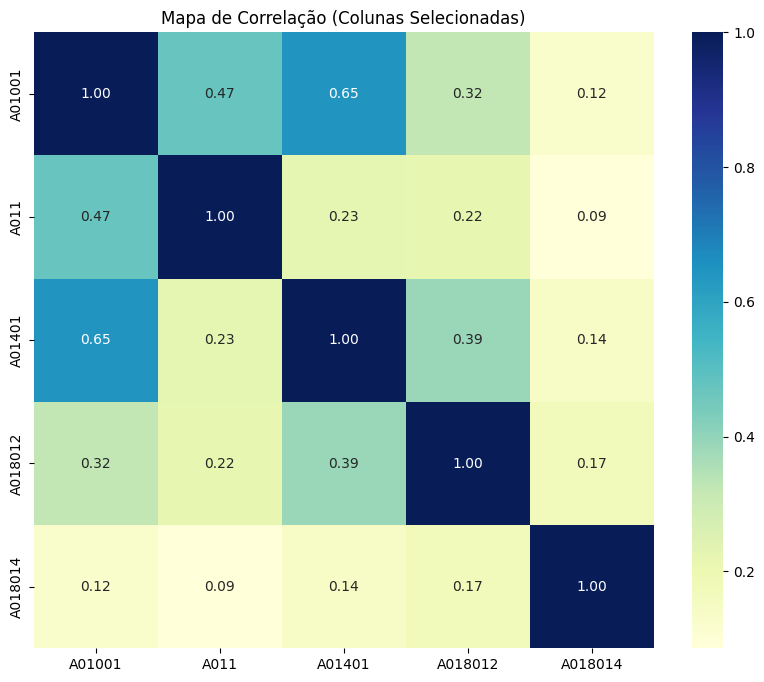

In [28]:
selected_columns = ["A01001", "A011", "A01401", "A018012", "A018014"] # só quantitativas

selected_data = data[selected_columns]

plt.figure(figsize=(10, 8))

sns.heatmap(selected_data.corr(), annot=True, cmap='YlGnBu', fmt=".2f")

plt.title("Mapa de Correlação (Colunas Selecionadas)")

plt.show()

Para tentar melhorar a correlação, o número de instâncias de cada classe será analisado, e posteriormente balanceado.

## Análise de distribuição de variáveis

### Balanceamento das classes

In [47]:
classes = data['A018023'].value_counts()
print(classes)

A018023
False    36073
True     11785
Name: count, dtype: int64


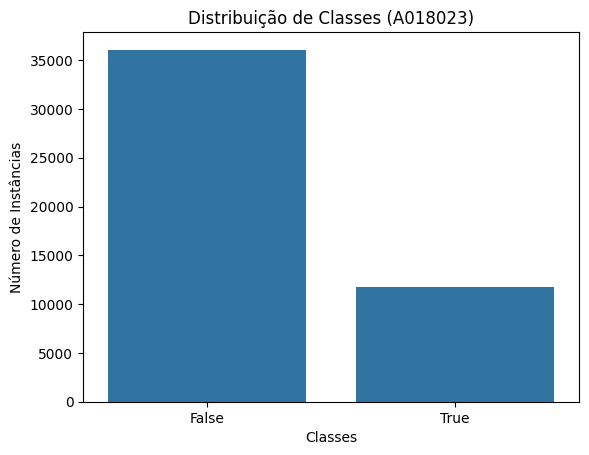

In [ ]:
sns.barplot(x = classes.index, y = classes.values)
plt.title('Distribuição de Classes (A018023)')
plt.ylabel('Número de Instâncias')
plt.xlabel('Classes')
plt.show()

In [ ]:
#para testar oversampling, comentar under. para usar undersampling, comentar over e para usar pesos, descomentar em modelos de classificação

X = data.drop('A018023',axis=1)
y = data['A018023']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#OVERSAMPLING
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train,y_train)
print("Distribuição das classes após o balanceamento com SMOTE:")
print(pd.Series(y_resampled).value_counts())
y_train = y_resampled
X_train = X_resampled

#UNDERSAMPLING
#rus = RandomUnderSampler(random_state=42)
#X_res, y_res = rus.fit_resample(X_train, y_train)
#print("Distribuição das classes após o balanceamento com Random:")
#print(pd.Series(y_res).value_counts())
#y_train = y_res
#X_train = X_res

Distribuição das classes após o balanceamento com SMOTE:
A018023
True     25251
False    25251
Name: count, dtype: int64


# Modelos de classificação

## Naive Bayes


Treinando e testando modelo: Naive Bayes
Acurácia (teste): 0.7193202395876863
Relatório de Classificação (teste):
              precision    recall  f1-score   support

       False       0.92      0.69      0.79     10822
        True       0.46      0.82      0.59      3536

    accuracy                           0.72     14358
   macro avg       0.69      0.75      0.69     14358
weighted avg       0.81      0.72      0.74     14358



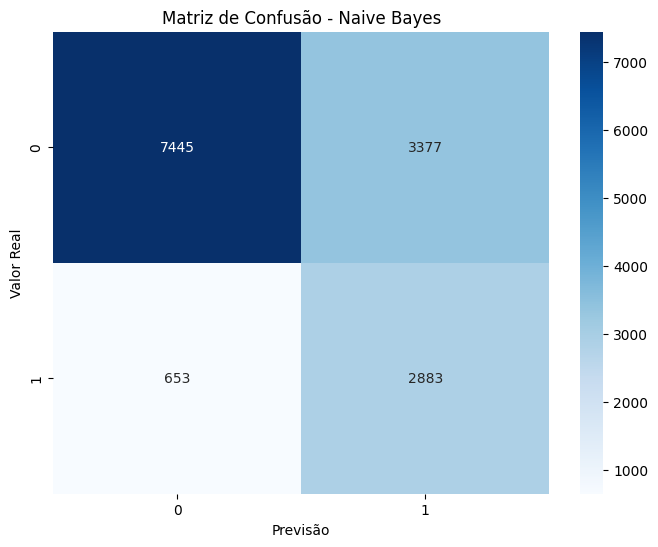

In [ ]:
clf_nb = GaussianNB()

print("\nTreinando e testando modelo: Naive Bayes")

clf_nb.fit(X_train, y_train)

y_pred_test_nb = clf_nb.predict(X_test)

print(f"Acurácia (teste): {accuracy_score(y_test, y_pred_test_nb)}")
print("Relatório de Classificação (teste):")
print(classification_report(y_test, y_pred_test_nb))

cm_nb = confusion_matrix(y_test, y_pred_test_nb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Naive Bayes')
plt.xlabel('Previsão')
plt.ylabel('Valor Real')
plt.show()

## Random Forest

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhores hiperparâmetros (Random Forest): {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 20}
Acurácia (teste): 0.8439894135673492
Relatório de Classificação (teste):
              precision    recall  f1-score   support

       False       0.91      0.88      0.89     10822
        True       0.67      0.74      0.70      3536

    accuracy                           0.84     14358
   macro avg       0.79      0.81      0.80     14358
weighted avg       0.85      0.84      0.85     14358



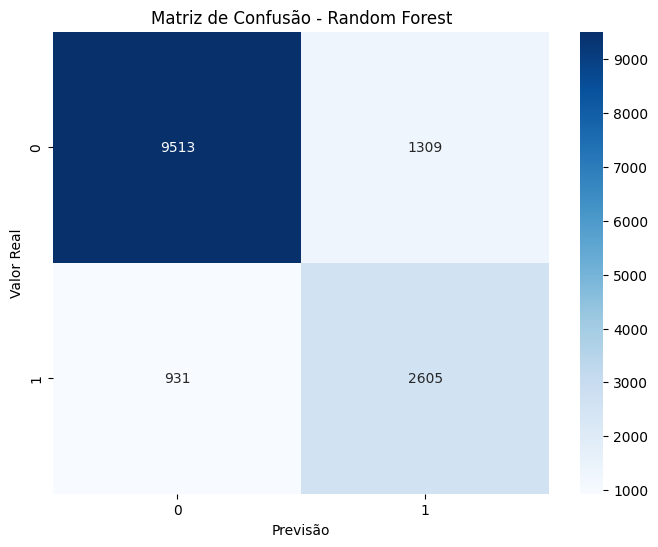

In [ ]:
clf_rf = RandomForestClassifier(random_state=42)

param_distributions_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search_rf = RandomizedSearchCV(estimator=clf_rf, param_distributions=param_distributions_rf,
                                      n_iter=10, cv=5, n_jobs=-1, random_state=42, verbose=2)
random_search_rf.fit(X_train, y_train)

print("Melhores hiperparâmetros (Random Forest):", random_search_rf.best_params_)

y_pred_test_rf = random_search_rf.predict(X_test)

print(f"Acurácia (teste): {accuracy_score(y_test, y_pred_test_rf)}")
print("Relatório de Classificação (teste):")
print(classification_report(y_test, y_pred_test_rf))

cm_rf = confusion_matrix(y_test, y_pred_test_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Random Forest')
plt.xlabel('Previsão')
plt.ylabel('Valor Real')
plt.show()

## Árvore de Decisão

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Melhores hiperparâmetros (Árvore de Decisão): {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Acurácia (teste): 0.834029809165622
Relatório de Classificação (teste):
              precision    recall  f1-score   support

       False       0.90      0.88      0.89     10822
        True       0.65      0.70      0.68      3536

    accuracy                           0.83     14358
   macro avg       0.78      0.79      0.78     14358
weighted avg       0.84      0.83      0.84     14358



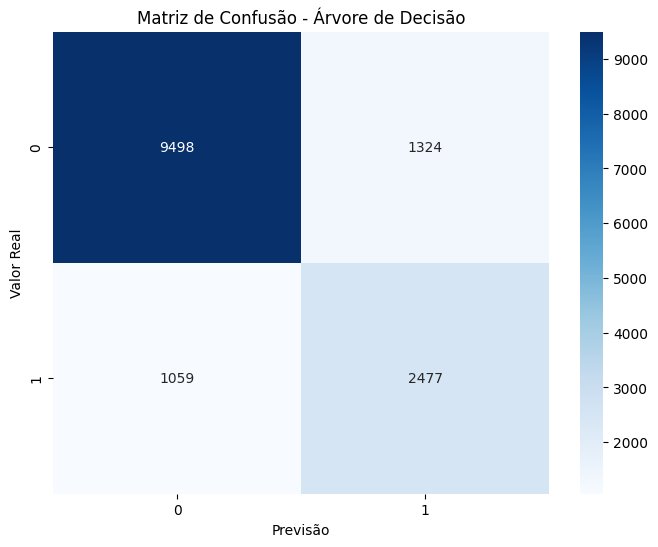

In [ ]:
clf_dt = DecisionTreeClassifier(random_state=42)

param_grid_dt = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_dt = GridSearchCV(estimator=clf_dt, param_grid=param_grid_dt, cv=5, n_jobs=-1, verbose=2)
grid_search_dt.fit(X_train, y_train)

print("Melhores hiperparâmetros (Árvore de Decisão):", grid_search_dt.best_params_)

y_pred_test_dt = grid_search_dt.predict(X_test)

print(f"Acurácia (teste): {accuracy_score(y_test, y_pred_test_dt)}")
print("Relatório de Classificação (teste):")
print(classification_report(y_test, y_pred_test_dt))

cm_dt = confusion_matrix(y_test, y_pred_test_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Árvore de Decisão')
plt.xlabel('Previsão')
plt.ylabel('Valor Real')
plt.show()

## Regressão Logística


Treinando e testando modelo: Logistic Regression


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Acurácia (teste): 0.8091656219529182
Relatório de Classificação (teste):
              precision    recall  f1-score   support

       False       0.91      0.83      0.87     10822
        True       0.59      0.74      0.65      3536

    accuracy                           0.81     14358
   macro avg       0.75      0.78      0.76     14358
weighted avg       0.83      0.81      0.82     14358



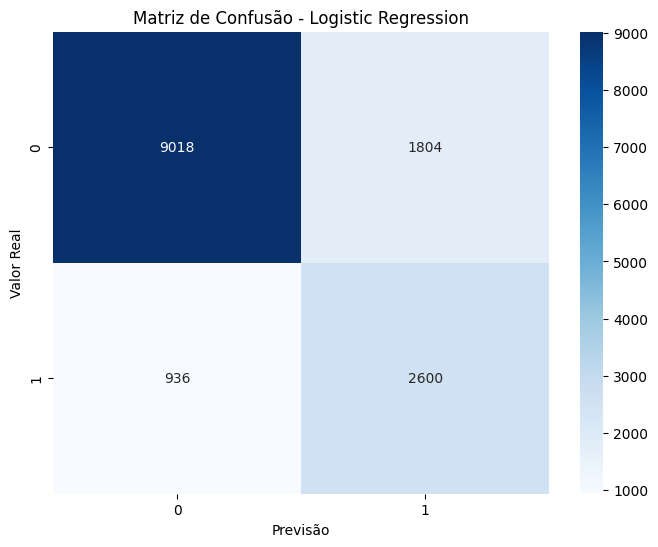

In [ ]:
clf_lr = LogisticRegression(random_state=42)

print("\nTreinando e testando modelo: Logistic Regression")

clf_lr.fit(X_train, y_train)

y_pred_test_lr = clf_lr.predict(X_test)

print(f"Acurácia (teste): {accuracy_score(y_test, y_pred_test_lr)}")
print("Relatório de Classificação (teste):")
print(classification_report(y_test, y_pred_test_lr))

cm_lr = confusion_matrix(y_test, y_pred_test_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Logistic Regression')
plt.xlabel('Previsão')
plt.ylabel('Valor Real')
plt.show()

## Knn


Treinando e testando modelo: KNN
Acurácia (teste): 0.8330547430004179
Relatório de Classificação (teste):
              precision    recall  f1-score   support

       False       0.93      0.84      0.88     10822
        True       0.63      0.80      0.70      3536

    accuracy                           0.83     14358
   macro avg       0.78      0.82      0.79     14358
weighted avg       0.85      0.83      0.84     14358



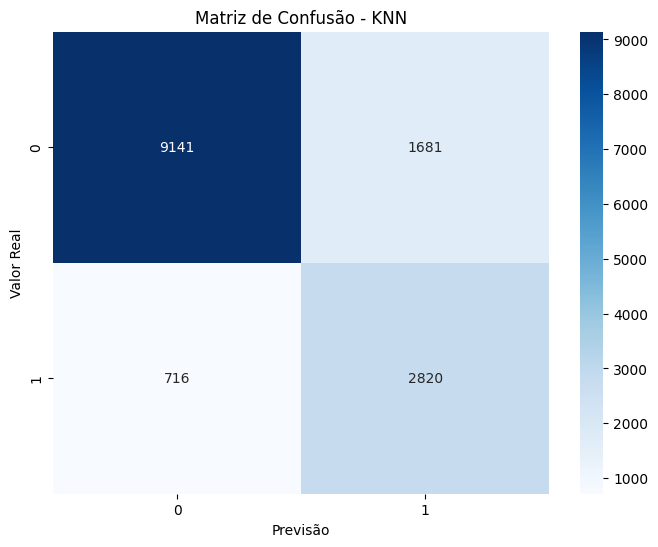

In [ ]:
clf_knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='euclidean')

print("\nTreinando e testando modelo: KNN")

clf_knn.fit(X_train, y_train)

y_pred_test_knn = clf_knn.predict(X_test)

print(f"Acurácia (teste): {accuracy_score(y_test, y_pred_test_knn)}")
print("Relatório de Classificação (teste):")
print(classification_report(y_test, y_pred_test_knn))

cm_knn = confusion_matrix(y_test, y_pred_test_knn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - KNN')
plt.xlabel('Previsão')
plt.ylabel('Valor Real')
plt.show()

## Self-Organizing Map(SOM)

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:


som = MiniSom(x=2, y=2, input_len=X_train.shape[1], sigma=0.8, learning_rate=0.2, random_seed=42)
som.random_weights_init(X_train)

print("Treinando SOM...")
som.train_random(data=X_train, num_iteration=100)

# 4. Mapeando os clusters
def map_clusters(som, data, labels):
    cluster_map = {}
    for x, label in zip(data, labels):
        winner = som.winner(x)  # Encontra o nó vencedor
        if winner not in cluster_map:
            cluster_map[winner] = []
        cluster_map[winner].append(label)
    return cluster_map

cluster_map = map_clusters(som, X_train, y_train)

# Rotula os clusters com base na maioria das classes em cada nó
cluster_labels = {cluster: max(set(labels), key=labels.count) for cluster, labels in cluster_map.items()}




Treinando SOM...


Matriz de Confusão:
[[7788 3034]
 [ 972 2564]]

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.89      0.72      0.80     10822
        True       0.46      0.73      0.56      3536

    accuracy                           0.72     14358
   macro avg       0.67      0.72      0.68     14358
weighted avg       0.78      0.72      0.74     14358



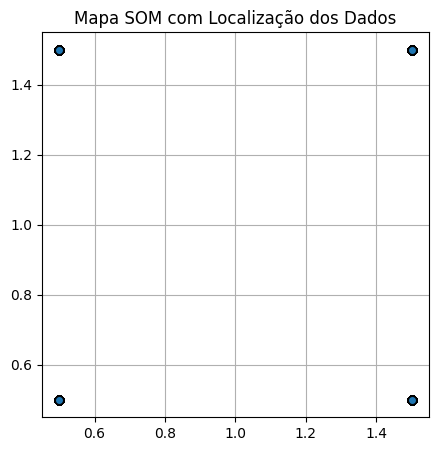

In [ ]:
# 5. Predição para os dados de teste
y_pred = []
for x in X_test:
    winner = som.winner(x)
    predicted_label = cluster_labels.get(winner, -1)  # Retorna -1 se não houver rótulo associado
    y_pred.append(predicted_label)

# 6. Avaliação do modelo
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))



plt.figure(figsize=(5, 5))
for i, x in enumerate(X_train):
    winner = som.winner(x)
    plt.plot(winner[0] + 0.5, winner[1] + 0.5, 'o', markerfacecolor='C0', markeredgecolor='k', markersize=6)
plt.title("Mapa SOM com Localização dos Dados")
plt.grid()
plt.show()


# Análise dos resultados

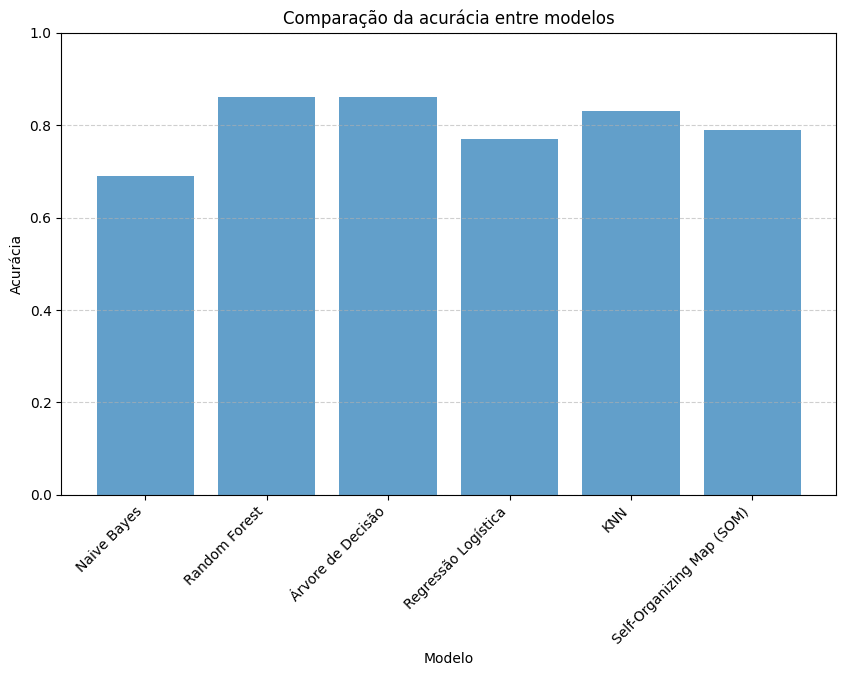

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Dados hipotéticos
models = ["Naive Bayes", "Random Forest", "Árvore de Decisão",
          "Regressão Logística", "KNN", "Self-Organizing Map (SOM)"]
accuracy = [0.69, 0.86, 0.86, 0.77, 0.83, 0.79]
precision_class_0 = [0.44, 0.72, 0.70, 0.54, 0.62, 0.58]
precision_class_1 = [0.93, 0.91, 0.93, 0.92, 0.95, 0.85]

# Criando DataFrame
metrics_df = pd.DataFrame({
    "Model": models,
    "Accuracy": accuracy,
    "Precision Class 0": precision_class_0,
    "Precision Class 1": precision_class_1
})

# Plotando a Acurácia
plt.figure(figsize=(10, 6))
plt.bar(metrics_df["Model"], metrics_df["Accuracy"], alpha=0.7)
plt.title("Comparação da acurácia entre modelos")
plt.ylabel("Acurácia")
plt.xlabel("Modelo")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()



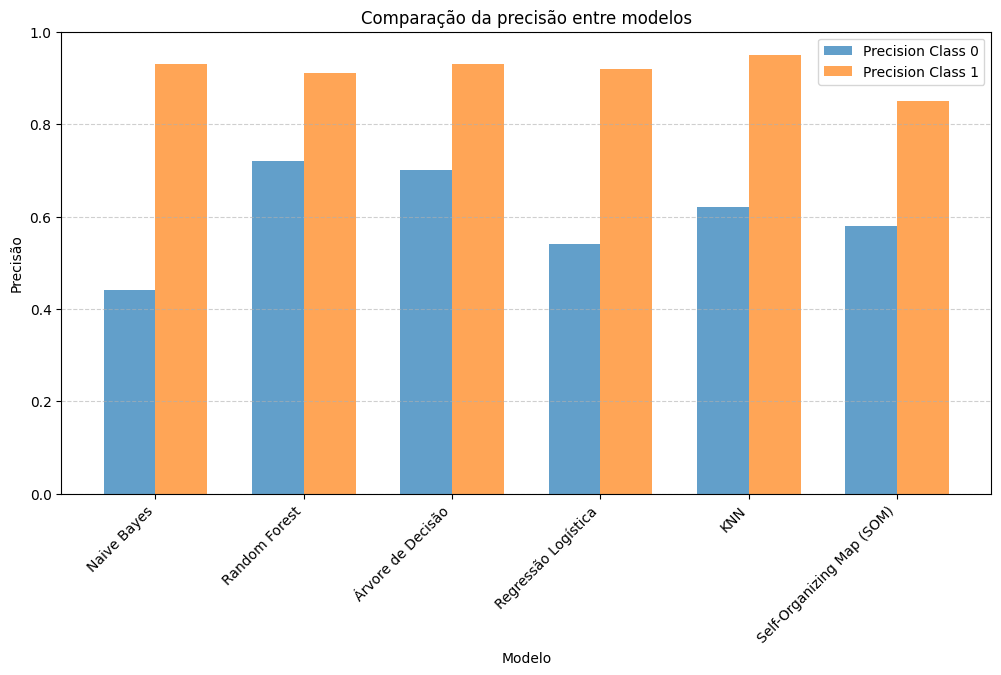

In [ ]:
# Plotando a Precisão
plt.figure(figsize=(12, 6))
bar_width = 0.35
x = range(len(models))

plt.bar(x, metrics_df["Precision Class 0"], width=bar_width, label="Precision Class 0", alpha=0.7)
plt.bar([p + bar_width for p in x], metrics_df["Precision Class 1"], width=bar_width, label="Precision Class 1", alpha=0.7)

plt.title("Comparação da precisão entre modelos")
plt.ylabel("Precisão")
plt.xlabel("Modelo")
plt.xticks([p + bar_width / 2 for p in x], models, rotation=45, ha="right")
plt.ylim(0, 1)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


Usar oversampling -> Não melhora nem piora acurácia, mas piora precisão na classe 1

Não usar oversampling nem undersampling e usar pesos -> Não altera acurácias, mas melhoras precisões na classe 1 em 5%.

Não balancear, não usar pesos -> mantém acurácias iguais a se usar oversampling, mas melhora precisões para classe em 1, que estavam baixas em todos os modelos, menos no naive, único que mantém a já baixa precisão. Isso indica que os dados gerados pelo oversampling, ou retirados no undersampling,  não ajudam no entendimentos da classe 1.

Usar undersampling -> também não melhorou precisão da classe 1